In [1]:
# importing the dependencies
import sklearn
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# loading the MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1, as_frame=False)

In [3]:
# lets check
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
# returns as a dictionary

In [6]:
mnist['DESCR']

str

In [7]:
mnist['data'].shape

(70000, 784)

In [8]:
mnist['target'].shape

(70000,)

In [9]:
# one thing to remember , sklearn already made a train, test split for the data
# and training set is already shuffled

In [10]:
X, y = mnist['data'],mnist['target']

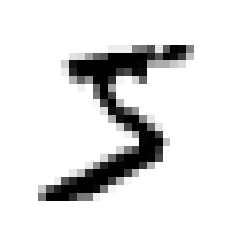

In [12]:
# Lets view and image
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt 

some_digit = X[0] 
# reshaping it
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=mpl.cm.binary)
plt.axis('off')
plt.show()

In [13]:
y[0]

'5'

In [14]:
# here y's are string, lets convert it to integers
y = y.astype(np.uint8)

In [15]:
# Lets do our train test split now
X_train, X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

#### Training a Binary classifier
Lets train a model to recognise only 5 first

In [18]:
y_train_5 = y_train==5 
y_test_5 = y_test==5
# remember this returns a boolean masking containing T/F

In [19]:
y_train_5.shape

(60000,)

In [20]:
# Lets train our model using SGD classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000,tol=1e-3,random_state=42,n_jobs=-1)
sgd_clf.fit(X_train,y_train)

SGDClassifier(n_jobs=-1, random_state=42)

In [30]:
# lets check the cross val score now
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [31]:
# lets predicts
# remember, some_digit was ONE instance, thus we need to pass it in a list to match
# the shape
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

### Performance Measure

#### Measuring Accuracy Using Cross-Validation

In [32]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)

for train_index,test_index in skfolds.split(X_train,y_train_5):
    # first clone our model
    clone_clf = clone(sgd_clf)
    # storing the folds
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [33]:
# Let check the Baseline accuracy
# A classifier that predicts its not 5 all the time
# The accuracy is high due to 90% of our dataset contains not 5
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool) # len(x): #of instance

In [34]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

#### Confusion MatriX

To compute the confusion matrix, you first need to have a set of
predictions so that they can be compared to the actual targets.

In [35]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [36]:
y_train_pred.shape

(60000,)

In [37]:
y_train_pred[:10]

array([ True, False, False, False, False, False, False, False, False,
       False])

In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred) #(y_true,y_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each
column represents a predicted class.

In [39]:
# calulating precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [40]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

- **Precision:** accuracy of the positive predictions. 

TP/(TP+FP); meaning the ration between TP and how many Negative examples my model predicted as Positive!
- **Recall**, also called sensitivity or the true positive rate (TPR): this is the ratio of positive instances that are correctly detected by the classifier. 

TP/(TP+FN): meaning the ration between TP and how many Positive examples my model predicted as Negative! (How many I positive examples I missed)

**F1 Score:** It is often convenient to combine precision and recall into a single metric
called the F 1 score, in particular if you need a simple way to compare two
classifiers.

Whereas the regular mean treats all values equally, theharmonic mean gives much more weight to low values. As a result, the
classifier will only get a high F 1 score if both recall and precision are high.

In [41]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

#### Precision Recall trade off

How do you decide which threshold to use? First, use the
cross_val_predict() function to get the scores of all instances in the
training set, but this time specify that you want to return decision scores
instead of predictions:

In [44]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [45]:
from sklearn.metrics import precision_recall_curve
precisions, recalls,threshold = precision_recall_curve(y_train_5,y_scores)

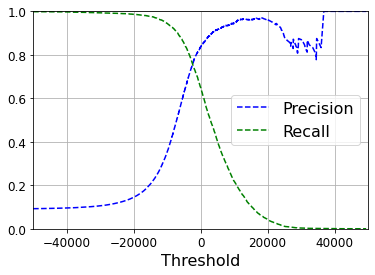

In [47]:
def plot_precision_recall_vs_threshold(precisions,recalls,threshold):
    plt.plot(threshold,precisions[:-1],"b--",label="Precision")
    plt.plot(threshold,recalls[:-1],"g--",label="Recall")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

plot_precision_recall_vs_threshold(precisions,recalls,threshold)
plt.show()

#### ROC Curve